In [1]:
from bnn_priors.models import LinearRegression, RaoBLinearRegression

import matplotlib.pyplot as plt
from matplotlib import collections as pltc
import numpy as np
import torch
from gpytorch.distributions import MultivariateNormal
from gpytorch.lazy import DiagLazyTensor, CholLazyTensor, RootLazyTensor


In [2]:
def n(t):
    try:
        return t.cpu().detach().numpy()
    except AttributeError:
        pass
    return t


def gp_posterior(ax, x, preds, label=None, sort=True, alpha=0.05, **kwargs):
    x = x.view(-1)
    if sort:
        # i = x.argsort(dim=-2)[:, 0]
        i = x.argsort()
        if i.equal(torch.arange(i.size(0))):
            i = slice(None, None, None)
    else:
        i = slice(None, None, None)
    x = x[i]

    preds_mean = preds.mean.view(-1)
    line, *_ = ax.plot(n(x), n(preds_mean[i]), **kwargs)
    if label is not None:
        line.set_label(label)

    C = line.get_color()
    lower, upper = (p.view(-1) for p in preds.confidence_region())
    ax.fill_between(n(x), n(lower[i]), n(upper[i]), alpha=alpha, color=C)
    ax.plot(n(x), n(lower[i]), color=C, linewidth=0.5)
    ax.plot(n(x), n(upper[i]), color=C, linewidth=0.5)


def expand_axis_limits(ax, x_min, x_max, y_min, y_max):
    old_x_min, old_x_max = ax.get_xlim()
    old_y_min, old_y_max = ax.get_ylim()
    ax.set_xlim(min(old_x_min, x_min), max(old_x_max, x_max))
    ax.set_ylim(min(old_y_min, y_min), max(old_y_max, y_max))


def gaussian_ellipses(ax, distribution, label=None, linewidth=0.5, **kwargs):
    "plots 2d Gaussian ellipses from a MultivariateNormal"
    if 'marker' not in kwargs:
        kwargs['marker'] = '+'
    coll = ax.scatter(n(distribution.mean[:, 0]), n(distribution.mean[:, 1]),
                      label=label, **kwargs)

    np_cov = n(distribution.covariance_matrix)
    np_mean = n(distribution.mean)
    eigvals, eigvecs = np.linalg.eigh(np_cov)
    # Factor is 4 because: 2 for .95 interval, 2 for radius up and down
    widths = 4*eigvals[:, 0]**.5
    heights = 4*eigvals[:, 1]**.5
    # arctan(y/x) for the eigenvector corresponding to the width
    angles = np.arctan(eigvecs[:, 1, 0]/eigvecs[:, 0, 0]) * (180/np.pi)

    ec = pltc.EllipseCollection(widths, heights, angles,
                                units='xy',
                                offsets=np_mean,
                                transOffset=ax.transData,
                                linewidths=linewidth,
                                edgecolor=coll.get_edgecolor(),
                                facecolor='none')
    ax.add_collection(ec)

    # Factor is 2 because of .95 interval
    marg_width = 2*np_cov[:, 0, 0]**.5
    marg_height = 2*np_cov[:, 1, 1]**.5

    x_min = np.min(np_mean[:, 0] - marg_width)
    x_max = np.max(np_mean[:, 0] + marg_width)
    y_min = np.min(np_mean[:, 1] - marg_height)
    y_max = np.max(np_mean[:, 1] + marg_height)
    expand_axis_limits(ax, x_min, x_max, y_min, y_max)


def lines(ax, points, linewidth=0.5, **kwargs):
    """
    Each element of `points` is a matrix of size [batch_size, 2], representing
    each of the x and y of this point in the sequence of lines.
    """
    ends = np.concatenate([n(p)[:, None, :] for p in points], axis=1)
    lc = pltc.LineCollection(ends, linewidth=linewidth, **kwargs)
    ax.add_collection(lc)

    x_min, y_min = np.min(ends, axis=(0, 1))
    x_max, y_max = np.max(ends, axis=(0, 1))
    expand_axis_limits(ax, x_min, x_max, y_min, y_max)
    return lc


def input_gaussian_posteriors(ax, train_x, train_y, train_x_true, train_y_true,
                              dist, draw_lines=True):
    train_x = train_x.view(-1)
    train_y = train_y.view(-1)
    dist_mean = dist.mean.view(-1)

    train = torch.stack([train_x, train_y], dim=1)
    train_true = torch.stack([train_x_true.view(-1), train_y_true.view(-1)],
                             dim=1)
    ax.scatter(train[:, 0], train[:, 1], marker='*', color='black')

    post_mean = torch.stack([dist_mean, train_y], dim=1)

    if draw_lines:
        c = lines(ax, [train, post_mean, train_true]).get_edgecolor().ravel()
    x_errorbars = dist.variance.view(-1).sqrt().mul(2)
    ax.errorbar(n(dist_mean), n(train_y), xerr=n(x_errorbars), elinewidth=0.5,
                capsize=2., linestyle='')


In [3]:
true_model = LinearRegression(1, 1, noise_std=0.5, std_w=1., std_b=1.)
true_model.sample_all_priors()

x_train = torch.randn(10).unsqueeze(-1)
y_train = true_model(x_train).sample()

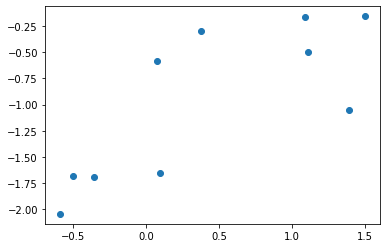

In [4]:
plt.scatter(x_train, y_train)

In [5]:
x_train_ones = torch.cat([x_train, torch.ones_like(x_train)], dim=1)

In [6]:
raob_model = RaoBLinearRegression(x_train_ones, y_train, noise_std=0.5, std_w=2**.5)

In [7]:
raob_model.posterior_w()

(tensor([[ 0.6524],
         [-1.2231]], dtype=torch.float64),
 tensor([[ 0.1799,  0.0000],
         [-0.0953,  0.1767]], dtype=torch.float64))

In [8]:
true_model.net.weight, true_model.net.bias

(Parameter containing:
 tensor([[0.9299]], requires_grad=True),
 Parameter containing:
 tensor([-1.3164], requires_grad=True))

In [9]:
x_test = torch.linspace(-3, 3, 20).unsqueeze(-1)
x_test_ones = torch.cat([x_test, torch.ones_like(x_test)], dim=1)

In [10]:
mu, L = raob_model.posterior_w()
posterior_w = MultivariateNormal(mu.unsqueeze(0).squeeze(-1), RootLazyTensor(L.t().unsqueeze(0)))
raob_dist = MultivariateNormal(x_test_ones.to(torch.float64) @ mu.squeeze(1), RootLazyTensor(x_test_ones.to(torch.float64) @ L.t()))

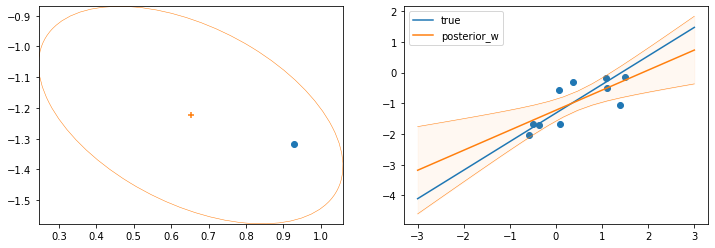

In [11]:
_, axes = plt.subplots(1, 2, figsize=(12, 4))
ax = axes[0]
ax.scatter(n(true_model.net.weight), n(true_model.net.bias))
gaussian_ellipses(ax, posterior_w)

ax = axes[1]
ax.scatter(x_train, y_train)
ax.plot(x_test, true_model(x_test).mean.detach(), label="true")
gp_posterior(ax, x_test, raob_dist, label="posterior_w")
ax.legend()

# Inferring the posterior with VerletSGLD

In [12]:
import bnn_priors.inference_reject
import torch.utils.data

In [13]:
class MetricsSaverLite(dict):
    def add_scalar(self, name, value, step, dtype=None):
        try:
            arr = self[name]
        except KeyError:
            arr = self[name] = []
        arr.append((step, value))
    def flush(self, every_s):
        pass

In [14]:
model = LinearRegression(1, 1, noise_std=0.5, std_w=1., std_b=1.)
#model = GaussianModel()

In [15]:
model.net.weight_prior._parameters

OrderedDict([('p',
              Parameter containing:
              tensor([[-1.2222]], requires_grad=True))])

In [16]:
dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=len(x_train),
                                         shuffle=False)

In [57]:
metrics_saver = MetricsSaverLite()
mcmc = bnn_priors.inference_reject.HMCRunnerReject(
    model=model,dataloader=dataloader, dataloader_test=dataloader,
                            epochs_per_cycle=5,
                            warmup_epochs=4, sample_epochs=1, learning_rate=0.01,
                            skip=1, metrics_skip=100, sampling_decay="flat", cycles=600, temperature=1.0,
                            momentum=1.0, precond_update=None,
                            metrics_saver=metrics_saver, model_saver=None, reject_samples=True)

In [58]:
mcmc.run(progressbar=False)

In [59]:
def plot_metric(ax, steps_metric, **kwargs):
    steps, metric = zip(*steps_metric)
    ax.plot(steps, metric, **kwargs)

metrics_saver.keys()

dict_keys(['preconditioner/net.weight_prior.p', 'est_temperature/net.weight_prior.p', 'est_config_temp/net.weight_prior.p', 'preconditioner/net.bias_prior.p', 'est_temperature/net.bias_prior.p', 'est_config_temp/net.bias_prior.p', 'est_temperature/all', 'est_config_temp/all', 'temperature', 'loss', 'acc', 'log_prior', 'potential', 'lr', 'acceptance/is_sample', 'delta_energy', 'total_energy', 'acceptance/rejected', 'test/log_prob', 'test/acc'])

In [60]:
samples = mcmc.get_samples()
weights, biases = samples["net.weight_prior.p"].view(-1),  samples["net.bias_prior.p"].view(-1)
_steps, rejected = zip(*metrics_saver["acceptance/rejected"][1:])
rejected = np.array(rejected, dtype=bool)

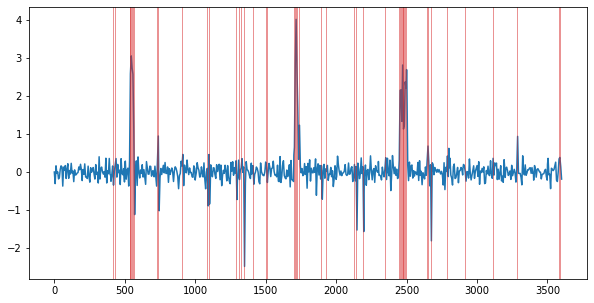

In [61]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))

#ax = axes[0]
plot_metric(ax, metrics_saver["delta_energy"])
for step, rejected in metrics_saver["acceptance/rejected"]:
    if rejected == 1:
        ax.axvline(step, linewidth=0.5, color="C3")
    elif rejected != 0:
        raise ValueError(rejected)
        
#axes.flat[1].plot(range(0, 500, 10), weights)
       
#axes.flat[1].plot(metrics_saver["est_temperature/all"])
#axes.flat[2].plot(metrics_saver["est_config_temp/all"])

In [54]:
from bnn_priors import mcmc
import math

n_samples = 600
sgld = mcmc.HMC(model.parameters(), lr=0.01, num_data=len(x_train))

weights = torch.zeros(n_samples)
biases = torch.zeros(n_samples)
rejected = np.zeros(n_samples, dtype=bool)
accept_prob = np.zeros(n_samples, dtype=float)

for sample in range(n_samples):
    if sample == 0:
        sgld.zero_grad()
        x, y = next(iter(dataloader))
        _initial_loss = model.potential_avg(x, y, len(x_train))
        _initial_loss.backward()
        loss = _initial_loss.item()
        
    initial_loss = loss
    sgld.sample_momentum()
    sgld.initial_step(save_state=True)
    for epoch in range(5):
        for x, y in dataloader:
            sgld.zero_grad()
            _loss = model.potential_avg(x, y, len(x_train))
            _loss.backward()
            sgld.step()

    x, y = next(iter(dataloader))
    _loss = model.potential_avg(x, y, len(x_train))
    loss = _loss.item()
    sgld.final_step()
    
    delta_energy = sgld.delta_energy(initial_loss, loss)
    this_rejected, log_accept_prob = sgld.maybe_reject(delta_energy)
    
    weights[sample] = model.net.weight.squeeze()
    biases[sample] = model.net.bias.squeeze()
    rejected[sample] = this_rejected
    accept_prob[sample] = math.exp(max(0., log_accept_prob))
    
weights = weights.detach()
biases = biases.detach()

In [55]:
rej_weights, rej_biases = weights[rejected].clone(), biases[rejected].clone()

for i in np.where(rejected)[0]:
    if i > 0:
        weights[i] = weights[i-1]
        biases[i] = biases[i-1]

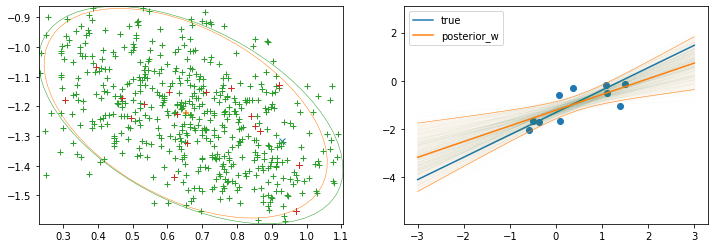

In [56]:
_, axes = plt.subplots(1, 2, figsize=(12, 4))
ax = axes[0]
ax.plot(n(true_model.net.weight), n(true_model.net.bias), marker="x", color="C0")
gaussian_ellipses(ax, posterior_w, color="C1")
ax.plot(weights, biases, marker='+', linewidth=0, label="samples", color="C2")
ax.plot(rej_weights, rej_biases, marker='+', linewidth=0, label="samples", color="C3")

WB = torch.stack([weights, biases], dim=1)[~rejected]
empirical_posterior_w = MultivariateNormal(WB.mean(0, keepdim=True),
                                           torch.from_numpy(np.cov(WB.numpy(), rowvar=False)).unsqueeze(0))
gaussian_ellipses(ax, empirical_posterior_w, color="C2")


ax = axes[1]
ax.scatter(x_train, y_train, color="C0")
ax.plot(x_test, true_model(x_test).mean.detach(), label="true", color='C0')
for w, b in zip(weights.numpy()[100:], biases.numpy()[100:]):
    ax.plot(x_test, x_test*w + b, color="C2", linewidth=0.5, alpha=0.01)
gp_posterior(ax, x_test, raob_dist, label="posterior_w", color="C1")
ax.legend()

# Inferring the posterior with HMC from Pyro

In [ ]:
from pyro.infer.mcmc import NUTS, HMC
from pyro.infer.mcmc.api import MCMC

In [ ]:
%pdb off
kernel = HMC(potential_fn=model.get_potential(x_train, y_train, eff_num_data=len(x_train)),
             adapt_step_size=False, adapt_mass_matrix=False,
             step_size=0.2, num_steps=10)


In [ ]:
mcmc = MCMC(kernel, num_samples=1000, warmup_steps=100, initial_params=model.params_dict())
mcmc.run(progressbar=True)

In [ ]:
samples = mcmc.get_samples()
weights, biases = samples["net.weight_prior.p"].view(-1),  samples["net.bias_prior.p"].view(-1)

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(12, 4))
ax = axes[0]
ax.plot(n(true_model.net.weight), n(true_model.net.bias), marker="x", color="C0")
gaussian_ellipses(ax, posterior_w, color="C1")
ax.plot(weights, biases, marker='.', linewidth=0, label="samples", color="C2")

WB = torch.stack([weights, biases], dim=1)
empirical_posterior_w = MultivariateNormal(WB.mean(0, keepdim=True),
                                           torch.from_numpy(np.cov(WB.numpy(), rowvar=False)).unsqueeze(0))
gaussian_ellipses(ax, empirical_posterior_w, color="C2")


ax = axes[1]
ax.scatter(x_train, y_train, color="C0")
ax.plot(x_test, true_model(x_test).mean.detach(), label="true", color='C0')
gp_posterior(ax, x_test, raob_dist, label="posterior_w", color="C1")
for w, b in zip(weights.numpy(), biases.numpy()):
    ax.plot(x_test, x_test*w + b, color="C2", linewidth=0.5)
ax.legend()